# **Exercise 1: Decision tree for classification task**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
from pprint import pprint
from numpy.random import seed, rand, randn
from IPython.display import display, Image
import math
seed(seed=3116)

## **Part A: Misclassification Rate as quaility-criterion**

In [ ]:
iris_data = pd.read_csv("https://raw.githubusercontent.com/Can-Berk/Machine_Learning_Labs/main/Datasets/iris.data", header=None)

In [ ]:
iris_data.columns = ["sepal_length","sepal_width","petal_length","petal_width","class"]

In [ ]:
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
print("Dataset dimensions=", np.shape(iris_data))
print(iris_data.isnull().any())

Dataset dimensions= (150, 5)
sepal_length    False
sepal_width     False
petal_length    False
petal_width     False
class           False
dtype: bool


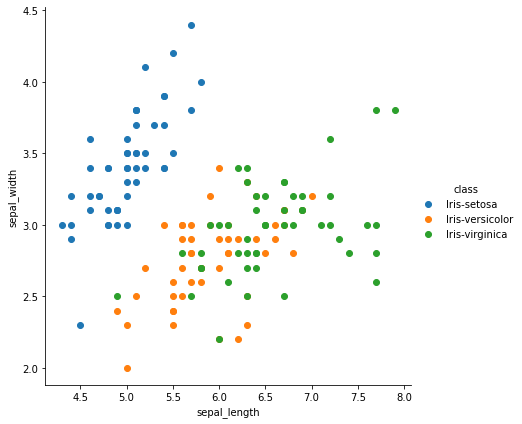

In [ ]:
sns.FacetGrid(iris_data, hue='class', height=6).map(plt.scatter,'sepal_length','sepal_width').add_legend()
plt.show()

In [ ]:
iris_data = iris_data.sample(frac=1,random_state=3116)

In [ ]:
def train(data,fraction1,fraction2):                 #To split dataset into train (70%), val (15%), test (15%)
    n = len(data)
    c=math.ceil((fraction1)*n)
    d=math.ceil((fraction2)*n)
    train = data.iloc[:c,:].reset_index(drop=True)
    return train

def val(data,fraction1,fraction2):                  #Validation data
    n = len(data)
    c=math.ceil((fraction1)*n)
    d=math.ceil((fraction2)*n)
    val = data.iloc[c:d,:].reset_index(drop=True)
    return val

def test(data,fraction1,fraction2):                 #Test data
    n = len(data)
    c=math.ceil((fraction1)*n)
    d=math.ceil((fraction2)*n)
    test = data.iloc[d:n,:].reset_index(drop=True)
    return test

In [ ]:
train_iris = train(iris_data,0.7,0.85)
val_iris = val(iris_data,0.7,0.85)
test_iris = test(iris_data,0.7,0.85)

In [ ]:
print("Train data len:",len(train_iris))
print("Val data len:",len(val_iris))
print("Test data len:",len(test_iris))

Train data len: 105
Val data len: 23
Test data len: 22


In [ ]:
print(test_iris.head())
print("Test data len:",len(test_iris))

   sepal_length  sepal_width  petal_length  petal_width            class
0           6.0          2.2           5.0          1.5   Iris-virginica
1           4.8          3.1           1.6          0.2      Iris-setosa
2           5.2          4.1           1.5          0.1      Iris-setosa
3           5.8          2.7           5.1          1.9   Iris-virginica
4           6.9          3.1           4.9          1.5  Iris-versicolor
Test data len: 22


In [ ]:
# def matrix_X(data):                    #convert to matrix form
#     ind_data = data.iloc[:,:-1]
#     X=ind_data.values
#     XT=X.T
#     X = np.vstack([np.ones(len(X)),XT]).T
#     return X


# def matrix_Y(data):
#     c = len(data.columns)
#     ind_data = data.iloc[:,c-1:c]
#     y=ind_data.values
#     return y

In [ ]:
# trainX = matrix_X(train_iris)
# trainy = matrix_Y(train_iris)
# valX = matrix_X(val_iris)
# valy = matrix_Y(val_iris)
# testX = matrix_X(test_iris)
# testy = matrix_Y(test_iris)

In [ ]:
# checking with sklearn - no need
# from sklearn.tree import DecisionTreeClassifier
# tree = DecisionTreeClassifier(criterion = 'entropy').fit(valX,valy)
# prediction = tree.predict(testX)
# print("The prediction accuracy is: ",tree.score(testX,testy)*100,"%")

In [ ]:
#MCR
def classification_error(y_col, p):
    elem,count = np.unique(y_col,return_counts = True)    
    return 1 - np.max([p, 1 - p])


def clf(data,split_attribute_name,col_name="class"):
    total_clf = classification_error(data[col_name],0.5)
    val,count= np.unique(data[split_attribute_name],return_counts=True)
    weighted_clf = np.sum([(count[i]/np.sum(count)) * classification_error(data.where(data[split_attribute_name]==val[i]).dropna()[col_name], 0.5) for i in range(len(val))])
    clf_result = total_clf - weighted_clf
    return clf_result

In [ ]:
def model_tree(data,data0,x_cols,y_col="class",class_parent_node = None):
    if len(np.unique(data[y_col])) <= 1:
        return np.unique(data[y_col])[0]
    elif len(data)==0:
        return np.unique(data0[y_col])[np.argmax(np.unique(data0[y_col],return_counts=True)[1])]    
    elif len(x_cols) ==0:
        return class_parent_node    
    else:
        class_parent_node = np.unique(data[y_col])[np.argmax(np.unique(data[y_col],return_counts=True)[1])]
        value_item = [information_gain(data,feature,y_col) for feature in x_cols]      #clf / Information gain
        inx_xcol_best = np.argmax(value_item)
        xcol_best = x_cols[inx_xcol_best]
        tree = {xcol_best:{}}
        x_cols = [i for i in x_cols if i != xcol_best]        
        for value in np.unique(data[xcol_best]):
            value = value
            subdata = data.where(data[xcol_best] == value).dropna()
            sub_tree = model_tree(subdata,iris_data,x_cols,y_col,class_parent_node)

            tree[xcol_best][value] = sub_tree            
        return tree

In [ ]:
def pred(data,tree,default = 1):    
    for key in list(data.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][data[key]] 
            except:
                return default
            result = tree[key][data[key]]
            if isinstance(result,dict):
                return pred(data,result)
            else:
                return result

a =[]            
def acc(data,tree):
    get_data = data.iloc[:,:-1].to_dict(orient = "records")
    pred_bar = pd.DataFrame(columns=["predicted"])
    pred_bar = pd.DataFrame(columns=["misclassified"])
    a.append(pred_bar)
    for i in range(len(data)):                    #calc. accuracy
        pred_bar.loc[i,"predicted"] = pred(get_data[i],tree,1.0)
        pred_bar.loc[i,"misclassified"] != pred(get_data[i],tree,1.0)
    print('The prediction accuracy is: ',(np.sum(pred_bar["predicted"] == data["class"])/len(data))*100,'%')
    print('The prediction misclassification is: ',(np.sum(pred_bar["misclassified"])/len(data))*100)

In [ ]:
tree = model_tree(train_iris,train_iris,train_iris.columns[:-1])      #train tree
pprint(tree)
acc(test_iris,tree)                                     #test accuracy

{'sepal_length': {4.3: 'Iris-setosa',
                  4.4: 'Iris-setosa',
                  4.5: 'Iris-setosa',
                  4.6: 'Iris-setosa',
                  4.7: 'Iris-setosa',
                  4.8: 'Iris-setosa',
                  4.9: {'sepal_width': {2.5: 'Iris-virginica',
                                        3.0: 'Iris-setosa',
                                        3.1: 'Iris-setosa'}},
                  5.0: {'sepal_width': {2.3: 'Iris-versicolor',
                                        3.2: 'Iris-setosa',
                                        3.4: 'Iris-setosa',
                                        3.5: 'Iris-setosa',
                                        3.6: 'Iris-setosa'}},
                  5.1: {'sepal_width': {2.5: 'Iris-versicolor',
                                        3.3: 'Iris-setosa',
                                        3.4: 'Iris-setosa',
                                        3.5: 'Iris-setosa',
                                     

## **Part B: Same dataset with Information gain quaility-criterion is used in model_tree**

In [ ]:
#Entropy
def entropy(y_col):
    elem,count = np.unique(y_col,return_counts = True)
    entropy = np.sum([(-count[i]/np.sum(count))*np.log2(count[i]/np.sum(count)) for i in range(len(elem))])
    #entropy = (p*np.log((1-p)/p) - np.log(1 - p)) / (2*np.log(2))
    return entropy


def information_gain(data,split_attribute_name,col_name="class"):  
    total_entropy = entropy(data[col_name])
    val,count= np.unique(data[split_attribute_name],return_counts=True)
    weighted_Entropy = np.sum([(count[i]/np.sum(count))*entropy(data.where(data[split_attribute_name]==val[i]).dropna()[col_name]) for i in range(len(val))])
    Information_Gain = total_entropy - weighted_Entropy
    return Information_Gain

In [ ]:
tree = model_tree(train_iris,train_iris,train_iris.columns[:-1])      #train tree
pprint(tree)
acc(test_iris,tree)                                     #test accuracy

{'petal_length': {1.0: 'Iris-setosa',
                  1.1: 'Iris-setosa',
                  1.2: 'Iris-setosa',
                  1.3: 'Iris-setosa',
                  1.4: 'Iris-setosa',
                  1.5: 'Iris-setosa',
                  1.6: 'Iris-setosa',
                  1.7: 'Iris-setosa',
                  1.9: 'Iris-setosa',
                  3.0: 'Iris-versicolor',
                  3.3: 'Iris-versicolor',
                  3.5: 'Iris-versicolor',
                  3.6: 'Iris-versicolor',
                  3.7: 'Iris-versicolor',
                  3.8: 'Iris-versicolor',
                  3.9: 'Iris-versicolor',
                  4.0: 'Iris-versicolor',
                  4.1: 'Iris-versicolor',
                  4.2: 'Iris-versicolor',
                  4.4: 'Iris-versicolor',
                  4.5: {'sepal_length': {4.9: 'Iris-virginica',
                                         5.4: 'Iris-versicolor',
                                         5.6: 'Iris-versicolor',
  

# **Exercise 2: Build a Gradient Boosted Decision Tree Classifier for a binary classification task**

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
#X, y = make_moons(n_samples=10, noise=0.1)

In [ ]:
noise_values = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1, 2, 5, 10]

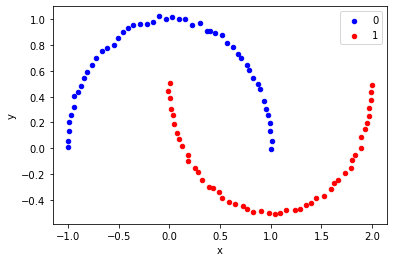

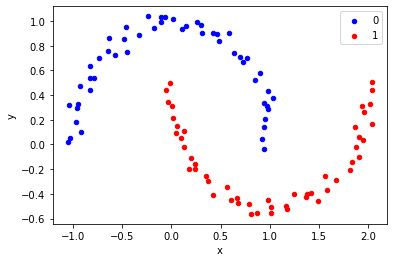

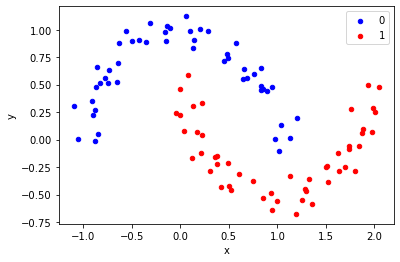

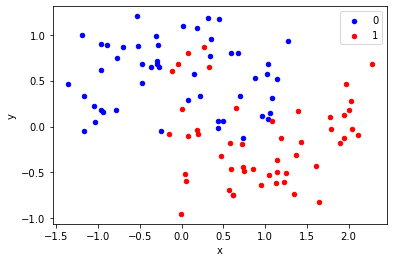

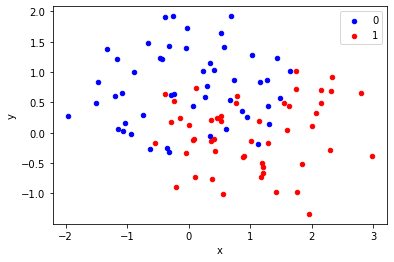

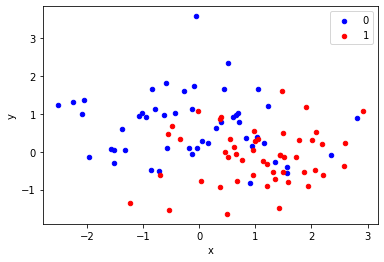

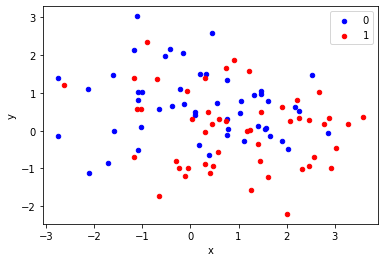

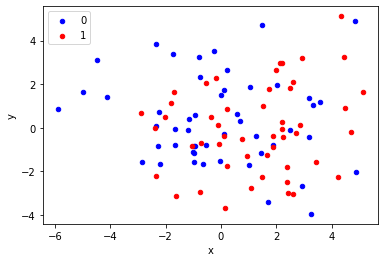

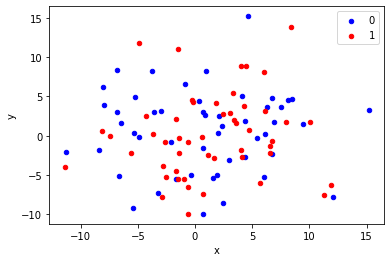

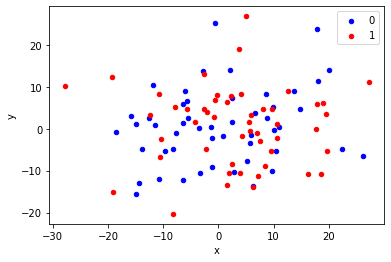

In [ ]:
moonX = []
moonY = []
for i in range(len(noise_values)):
    #print("Noise value=",noise_values[i])
    X, y = make_moons(n_samples=100, noise=noise_values[i])
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = {0:'blue', 1:'red'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()
    #print(X,y)
    moonX.append(X)
    moonY.append(y)

In [ ]:
print("moonX dimension:",np.shape(moonX))
print("moonY dimension:",np.shape(moonY))

moonX dimension: (10, 100, 2)
moonY dimension: (10, 100)


In [ ]:
x = np.concatenate(moonX)
y = np.concatenate(moonY)
print("x dimension:",np.shape(x))
print("y dimension:",np.shape(y))

x dimension: (1000, 2)
y dimension: (1000,)


In [ ]:
moons = np.column_stack([x, y])

In [ ]:
moons = pd.DataFrame(moons)
moons.columns = ["x1","x2","y"]
print(moons.head())
print("moons dims:",np.shape(moons))

         x1        x2    y
0  0.432202 -0.305791  1.0
1  0.182497 -0.053953  1.0
2  0.524026 -0.388200  1.0
3 -0.667479  0.751305  0.0
4  0.769349 -0.472927  1.0
moons dims: (1000, 3)


In [ ]:
moons = moons.sample(frac=1,random_state=3116)

In [ ]:
def train(data,fraction1,fraction2):                 #To split dataset into train (70%), val (15%), test (15%)
    n = len(data)
    c=math.ceil((fraction1)*n)
    d=math.ceil((fraction2)*n)
    train = data.iloc[:c,:].reset_index(drop=True)
    return train

def val(data,fraction1,fraction2):                  #Validation data
    n = len(data)
    c=math.ceil((fraction1)*n)
    d=math.ceil((fraction2)*n)
    val = data.iloc[c:d,:].reset_index(drop=True)
    return val

def test(data,fraction1,fraction2):                 #Test data
    n = len(data)
    c=math.ceil((fraction1)*n)
    d=math.ceil((fraction2)*n)
    test = data.iloc[d:n,:].reset_index(drop=True)
    return test

In [ ]:
train_moons = train(moons,0.7,0.85)
val_moons = val(moons,0.7,0.85)
test_moons = test(moons,0.7,0.85)

In [ ]:
print("Train data len:",len(train_moons))
print("Val data len:",len(val_moons))
print("Test data len:",len(test_moons))

Train data len: 700
Val data len: 150
Test data len: 150


In [ ]:
x = pd.DataFrame({'x1': moons.iloc[:,0], 'x2': moons.iloc[:,1]})
y = y[:,None]

In [ ]:
x.shape, y.shape

((1000, 2), (1000, 1))

In [ ]:
# def matrix_X(data):                    #convert to matrix form for sklearn check
#     ind_data = data.iloc[:,:-1]
#     X=ind_data.values
#     XT=X.T
#     X = np.vstack([np.ones(len(X)),XT]).T
#     return X


# def matrix_Y(data):
#     c = len(data.columns)
#     ind_data = data.iloc[:,c-1:c]
#     y=ind_data.values
#     return y

In [ ]:
# trainX = matrix_X(train_moons)
# trainy = matrix_Y(train_moons)
# valX = matrix_X(val_moons)
# valy = matrix_Y(val_moons)
# testX = matrix_X(test_moons)
# testy = matrix_Y(test_moons)

In [ ]:
# #with sklearn
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier()
# model.fit(trainX, trainy)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, testX, testy, scoring='accuracy', cv=cv, n_jobs=-1)
# print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
#Without sklearn

In [ ]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

In [ ]:
def stddev_agg(cnt, s1, s2):
    return math.sqrt(np.abs((s2/cnt) - (s1/cnt)**2))

In [ ]:
class tree_model():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.split_find()
        
    def split_find(self):
        for i in range(self.c): self.better_split_find(i)
        if self.score == float('inf'): return
        x = self.split_colm
        lhs = np.nonzero(x<=self.split)[0]            #holds the sample of features for left tree
        rhs = np.nonzero(x>self.split)[0]             #holds the sample of features for right tree
        self.lhs = tree_model(self.x, self.y, self.idxs[lhs])         #holds left decision tree
        self.rhs = tree_model(self.x, self.y, self.idxs[rhs])         #hold right decision tree

    def better_split_find(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            x_i,y_i = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += y_i; rhs_sum -= y_i
            lhs_sum2 += y_i**2; rhs_sum2 -= y_i**2
            if i<self.min_leaf or x_i==sort_x[i+1]:
                continue

            lhs_std = stddev_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = stddev_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,x_i

    @property
    def split_colm(self):
        return self.x.values[self.idxs,self.var_idx]

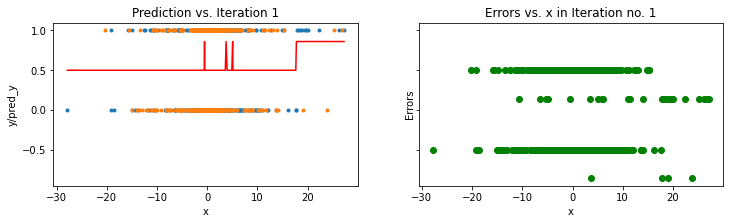

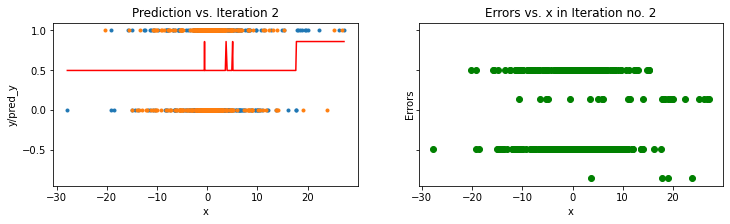

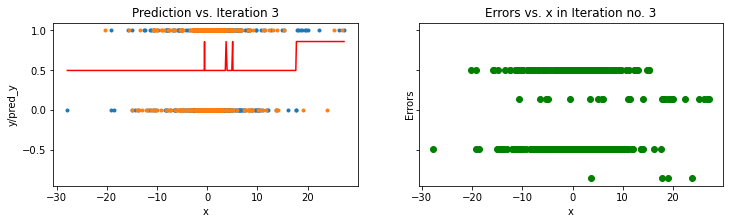

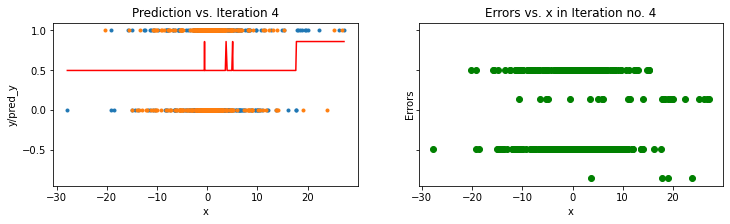

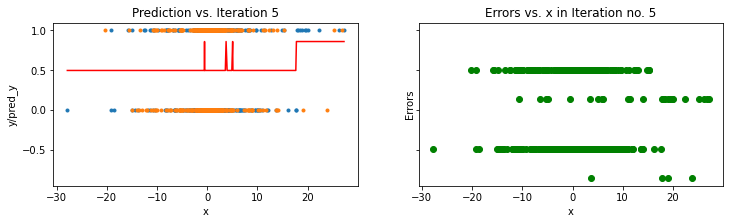

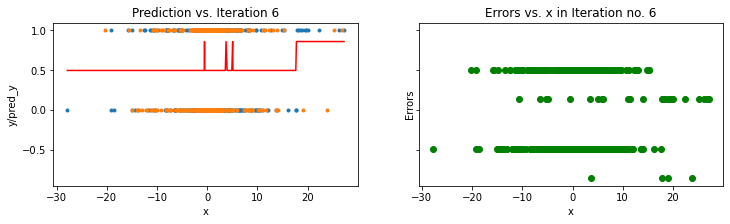

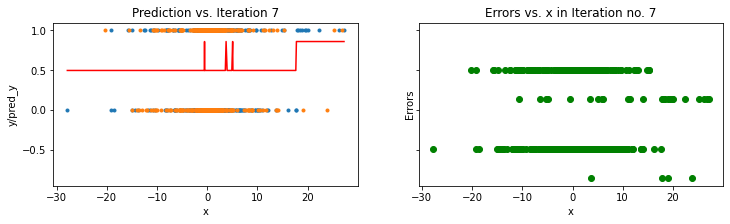

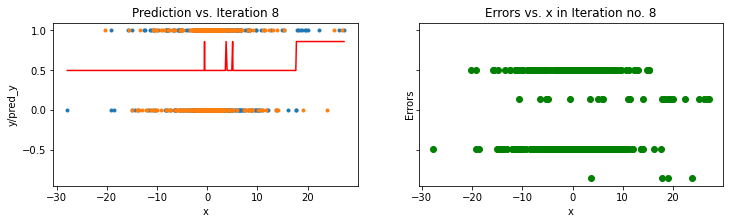

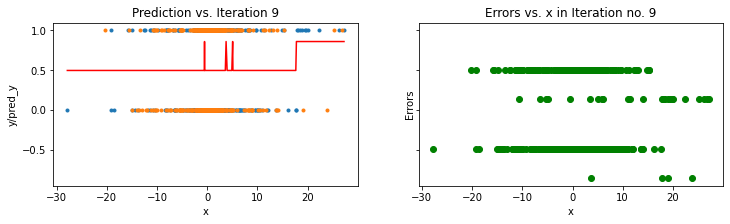

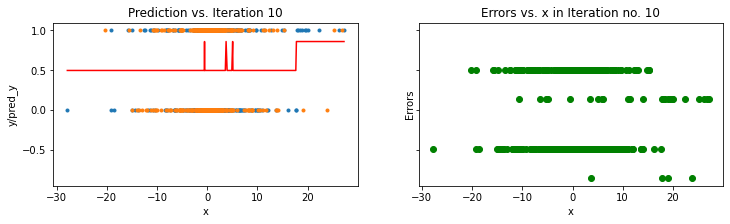

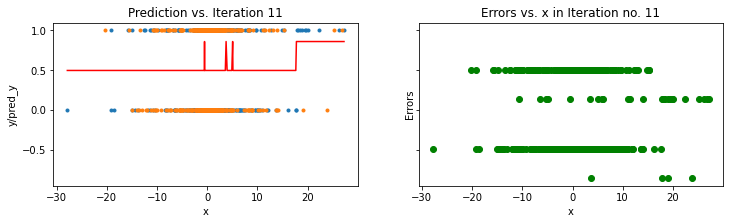

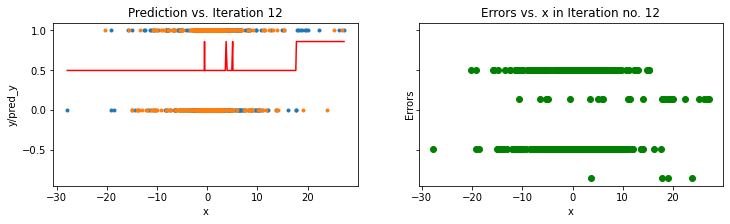

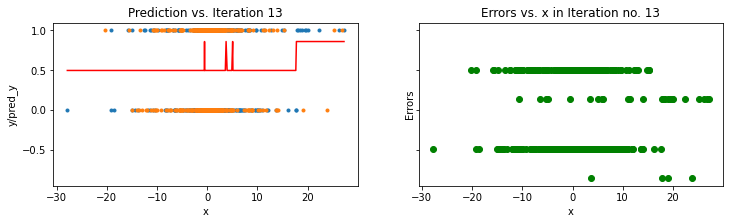

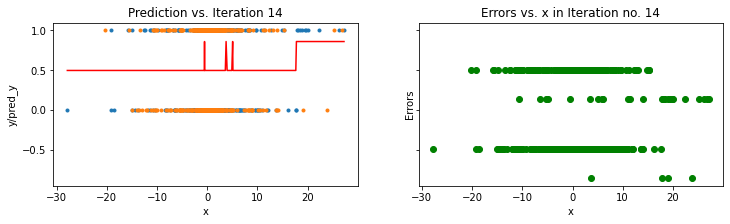

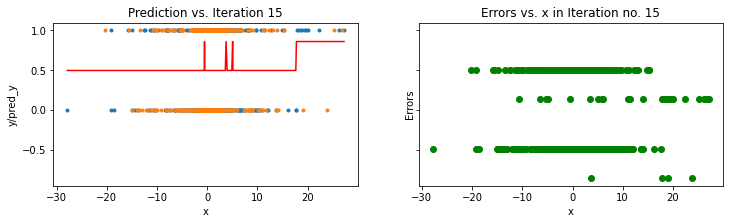

In [ ]:
x_i = moons.iloc[:,0:2]                 #x input
y_i = y                                 #target y
n = len(y_i)                            #number of rows
e_i = 0                                 #error track
pred_f = 0                              #prediction track

for i in range(15):
    tree = tree_model(x_i,y_i)
    tree.better_split_find(0)    
    r = np.where(x_i == tree.split)[0][0]        
    idx_left = np.where(x_i <= tree.split)[0]            #splitting tree
    idx_right = np.where(x_i > tree.split)[0]
    
    pred_i = np.zeros(n)
    np.put(pred_i, idx_left, np.repeat(np.mean(y_i[idx_left]), r))  #replace left side mean y
    np.put(pred_i, idx_right, np.repeat(np.mean(y_i[idx_right]), n-r))  #right side mean y    
    pred_i = pred_i[:,None]           #make long vector (nx1) in compatible with y
    pred_f = pred_f + pred_i          #new prediction of residual added to final prediction    
    e_i = y - pred_f   
    y_i = e_i # update y_i as residual to reloop
    
    x_a = np.array(x.x1) # column name of x is x 
    sort_xa = np.argsort(x_a)
    x_s = np.array(x_a)[sort_xa]
    y_s = np.array(pred_f)[sort_xa]
    

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,3))       #plots
    ax1.plot(x, y, '.')
    ax1.plot(x_s, y_s, 'r')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y/pred_y')
    ax1.set_title(f'Prediction vs. Iteration {i+1}')
    
    ax2.plot(x, e_i, 'go')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Errors')
    ax2.set_title(f'Errors vs. x in Iteration no. {i+1}')

# References
###https://www.python-course.eu/Decision_Trees.php
###https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
###https://www.ismll.uni-hildesheim.de/lehre/ba-18w/script/4_predictive-analytics-xgboost.pdf
###https://dataaspirant.com/gradient-boosting-algorithm/
###https://www.kaggle.com/grroverpr/gradient-boosting-simplified
###https://sefiks.com/2018/08/27/a-step-by-step-cart-decision-tree-example/
###https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775